In [7]:
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
from utils.matrix import project_points, project_covariance, to_homogeneous
from utils.colmap_data import COLMAP_Data
from utils.plot_utils import create_ellipsoids_as_one_mesh, plot_covariance, plot_points
from src.gaussian import GaussianSplatting
from scipy.stats import chi2

try:
    import cuda_backend
except:
    from cuda_backend import add
    print('Need to fix cuda import')

In [15]:
colmap_data = COLMAP_Data("data/sparse/0")
model = GaussianSplatting(colmap_data)
sigmas = model.init_gaussian_covariance()

frame_idx = 1
E = colmap_data.E[colmap_data.frame_names[frame_idx]]
K = colmap_data.K
distortion = colmap_data.distortion
points = colmap_data.points
colors = colmap_data.colors
width = colmap_data.width
height = colmap_data.height

print(colmap_data.frame_names[frame_idx])
print(points.shape)

frame_00001.png
(56042, 3)


In [3]:
sigmas_2d = project_covariance(points, sigmas, E, K)
points_2d, depths = project_points(points, E, K, return_depth=True)

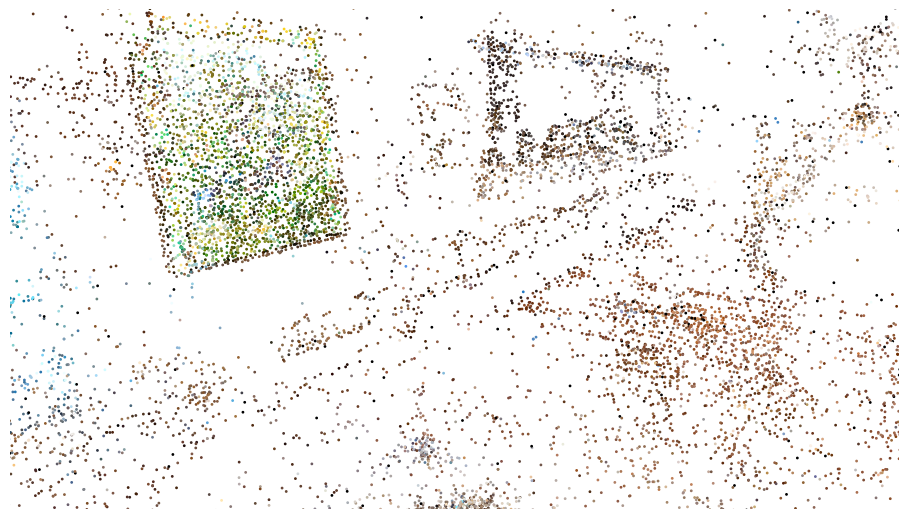

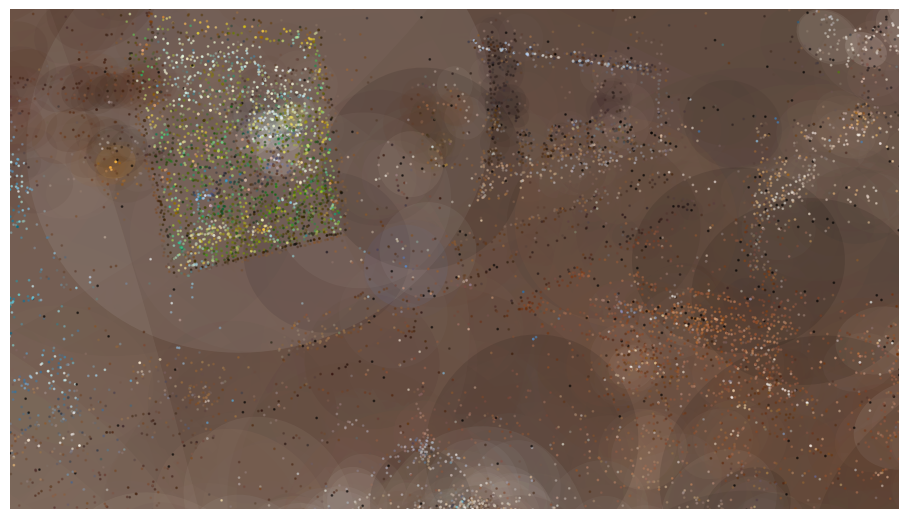

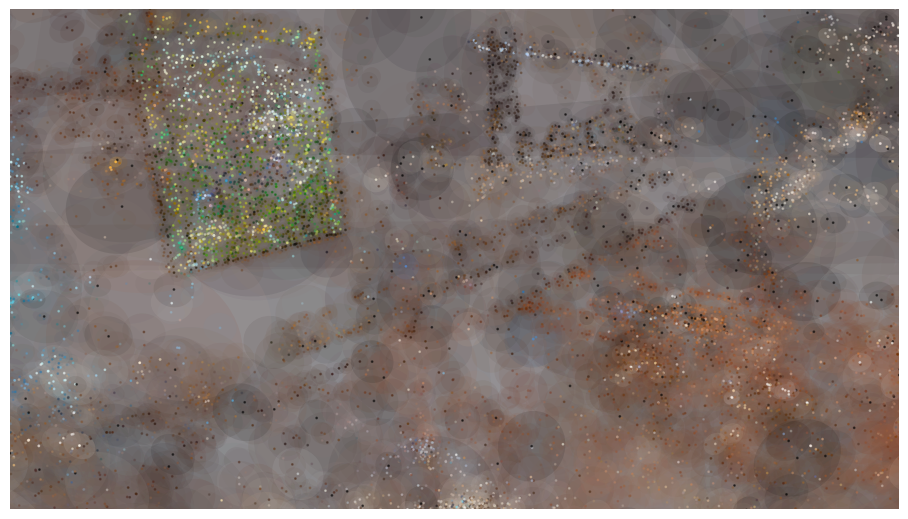

In [4]:
# 3d visualization
viz_scaling = 0.1
big_mesh = create_ellipsoids_as_one_mesh(model.points, sigmas*viz_scaling, model.colors, sphere_resolution=10)
o3d.visualization.draw_geometries([big_mesh])

# 2d visualization (x right y down z up, like pixels)
plot_points(points_2d, colors, width=width, height=height)
plot_covariance(points_2d, sigmas_2d, colors, scale=1, width=width, height=height)
plot_covariance(points_2d, sigmas_2d, colors, scale=0.1, width=width, height=height)

In [5]:

# naive culling
# bound_indices = (points_2d >= 0).all(axis=1) & \
#     (points_2d < [colmap_data.width, colmap_data.height]).all(axis=1)

## 99% confidence interval in view frustum
"""
99% confidence interval for 2D Gaussian: χ2,2_0.992 ≈3.04
Confidence ellipsoid is scaled by 3.04 times the eigenvalues of the covariance matrix.
"""

def get_covariance_bounds(sigmas_2d):
    chi2_threshold = chi2.ppf(0.99, df=2)  # 99% confidence interval for 2D Gaussian

    scale_squared, rotation = np.linalg.eigh(sigmas_2d * 0.1)
    extents = np.sqrt(scale_squared * chi2_threshold)
    return extents

bound_indices = []
extents = get_covariance_bounds(sigmas_2d)
points_min = points_2d - extents
points_max = points_2d + extents

# Check all bounds conditions in a vectorized way
# check 99% confidence interval and depth is positive
in_bounds = (points_min[:, 0] > 0) & (points_min[:, 1] > 0) & \
            (points_max[:, 0] < colmap_data.width) & (points_max[:, 1] < colmap_data.height) & \
            (depths > 0)
bound_indices = np.where(in_bounds)[0]

In [6]:
bounded_points_2d = points_2d[bound_indices]
bounded_colors = colmap_data.colors[bound_indices]
bounded_depths = depths[bound_indices]

bounded_sigmas_2d = sigmas_2d[bound_indices]
bounded_sigmas = sigmas[bound_indices]
bounded_extents = extents[bound_indices]

In [16]:
# Test matrices by back-projecting tile pixel space to 3D space

tile_x1 = 0
tile_x2 = width
tile_y1 = 0
tile_y2 = height 
tile_pixels = np.array([[tile_x1, tile_y1], 
                        [tile_x2, tile_y1], 
                        [tile_x1, tile_y2], 
                        [tile_x2, tile_y2]])

# depth = None
for idx in range(len(bounded_points_2d)):
    depth = bounded_depths[idx]

    tile_cam = to_homogeneous(tile_pixels) @ np.linalg.inv(K).T * depth
    tile_world = (to_homogeneous(tile_cam) @ np.linalg.inv(E).T)
    # normalize if we want to get a ray, without original depth
    if depth is None:
        tile_world = tile_world[:, :3] / tile_world[:, 3:]
    else:
        tile_world = tile_world[:, :3]

    current_point = points[bound_indices][idx]

    assert tile_world[:, 0].min() <= current_point[0] <= tile_world[:, 0].max()
    assert tile_world[:, 1].min() <= current_point[1] <= tile_world[:, 1].max()
    assert tile_world[:, 2].min() <= current_point[2] <= tile_world[:, 2].max()

print(f'All back-projected points are in the view frustum for frame {colmap_data.frame_names[1]}')

All back-projected points are in the view frustum for frame frame_00001.png


In [17]:
# currently only checks one corner of the tile
# also unoptimized
def get_splats_per_tile(tiles, points_2d, extents):
    tiles_expanded = tiles[:, np.newaxis, :]  # Shape: (2135, 1, 2)
    points_expanded = points_2d[np.newaxis, :, :]  # Shape: (1, 8108, 2)
    extent_expanded = extents[np.newaxis, :, :]  # Shape: (1, 8108, 2)

    x_dist = (tiles_expanded[:, :, 0] - points_expanded[:, :, 0])**2  # Shape: (2135, 8108)
    y_dist = (tiles_expanded[:, :, 1] - points_expanded[:, :, 1])**2  # Shape: (2135, 8108)

    dist = (x_dist / extent_expanded[:, :, 0]**2 + y_dist / extent_expanded[:, :, 1]**2)  # Shape: (2135, 8108)

    in_ellipse_mask = dist <= 1  # Shape: (2135, 8108)

    points_indices_per_tile = [np.where(in_ellipse_mask[i])[0] for i in range(len(tiles))]
    return points_indices_per_tile

In [67]:
# for each tile, get list of gaussian indices

# TODO: GPU radix sort with cuda
    # Radix sort O(n+d): [32b`depth - 32b`tile_idx] 64 bits 

n = 16
padding_x = (width % n) // 2
padding_y = (height % n) // 2
tiles = np.array(np.meshgrid(np.arange(padding_x, width+padding_x, n), 
                        np.arange(padding_y, height+padding_y, n))).T.reshape(-1, 2)

points_indices_per_tile = get_splats_per_tile(tiles, bounded_points_2d, bounded_extents)

# sort by depth
for i in range(len(points_indices_per_tile)):
    points_indices_per_tile[i] = points_indices_per_tile[i][np.argsort(bounded_depths[points_indices_per_tile[i]])]

##### 𝐼 ← Rasterize(𝑀, 𝑆, 𝐶, 𝐴, 𝑉)
<div style="font-size: 80%">

$C = \sum_{i=1}^N T_i \alpha_i c_i$

where:

$\alpha_i = (1 - \exp(-\sigma_i \delta_i)), \quad T_i = \prod_{j=1}^{i-1} (1 - \alpha_j)$

Thus:

$C = \sum_{i \in N} c_i \alpha_i \prod_{j=1}^{i-1} (1 - \alpha_j)$

Also, density of gaussian at a point is:

$G(x) = \frac{1}{2\pi |\Sigma|^{1/2}} \exp\left(-\frac{1}{2} (x - \mu)^T \Sigma^{-1} (x - \mu)\right)$

</div>

In [88]:
# 𝐼 ← Rasterize(𝑀, 𝑆, 𝐶, 𝐴, 𝑉)
# TODO: Accumulate color and alpha from front to back until we reach target saturation (T_alpha)
# TODO: GPU rasterization

def sigmoid(z):
    return 1/(1 + np.exp(-z))

# 𝛼𝑖 is given by evaluating a 2D Gaussian with covariance Σ [Yifan et al. 2019] multiplied with a learned per-point opacity
coeff = 1 / (2 * np.pi * np.sqrt(np.linalg.det(bounded_sigmas_2d)))
curr_sigmas_2d_inv = np.linalg.inv(bounded_sigmas_2d)

canvas = np.zeros((width, height, 3))

for tile_idx in range(len(tiles)):
    curr_point_indices = points_indices_per_tile[tile_idx]
    if len(curr_point_indices) == 0: # arbitrary number for debugging
        continue

    # create pixels for each tile for each
    x_start, y_start = tiles[tile_idx]
    x = np.arange(x_start, x_start+n-1, 1)
    y = np.arange(y_start, y_start+n-1, 1)

    X, Y = np.meshgrid(x, y)
    XY = np.stack([X, Y], axis=-1).reshape(-1, 2)

    # (n_pixels, n_gaussians, xy)
    d = (XY[:, np.newaxis] - bounded_points_2d[curr_point_indices][np.newaxis, :])

    s = curr_sigmas_2d_inv[curr_point_indices] # (n_gaussians, xy, xy)

    # d @ s @ d.T
    # (n_pixels, n_gaussians, xy) @ (n_gaussians, xy, xy) @ (n_pixels, xy, n_gaussians)
    # --> (n_pixels, n_gaussians)
    densities = coeff[curr_point_indices] * np.exp(-0.5 * np.einsum('ngx, gxy, ngx->ng', d, s, d))
    deltas = bounded_depths[curr_point_indices]
    alphas = 1 - np.exp(-densities * deltas)
    # 5.1 constrain it in the [0 − 1) range and obtain smooth gradients
    alphas = sigmoid(alphas)

    # TODO: double check equation
    T = np.cumprod(1 - alphas, axis=1)

    # c @ alpha @ T
    # (n_gaussians, rgb) @ (n_pixels, n_gaussians) @ (n_pixels, n_gaussians)
    # --> (n_pixels, rgb)
    point_colors = bounded_colors[curr_point_indices]

    # TODO: instead of multiplying, we should add it to alpha channel
    pixel_colors = np.einsum('gc, ng, ng->nc', point_colors, alphas, T).reshape(n-1, n-1, 3)

    # clip edges if image doesn't fit
    if x_start+n-1 > width:
        pixel_colors = pixel_colors[:width-x_start, :]
    if y_start+n-1 > height:
        pixel_colors = pixel_colors[:, :height-y_start]
    canvas[x_start:x_start+n-1, y_start:y_start+n-1] = pixel_colors

In [92]:
point_colors

array([[0.5254902 , 0.26666667, 0.09019608]])

In [85]:
canvas = canvas.transpose(1, 0, 2)

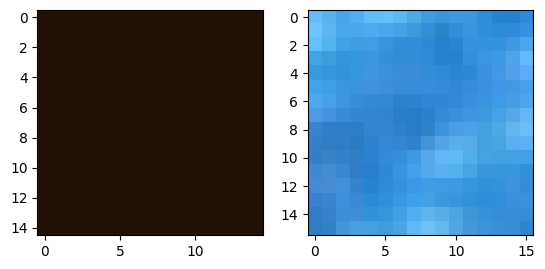

In [86]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(pixel_colors)

img_name = colmap_data.frame_names[frame_idx]
img = plt.imread(f"data/images/{img_name}")
tile = img[:16, :16]
axs[1].imshow(tile)
plt.show()

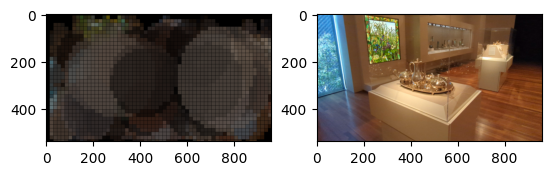

In [87]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(canvas)
axs[1].imshow(img)
plt.show()